<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

# Setup
(No need to change anything)

In [1]:
import seaborn as sns

In [2]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-cwkozaun
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-cwkozaun
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 829084a53836c5b8b388aa37a5ffce73b6371712
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.6 MB/s eta 0:00:00
    

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [4]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [5]:
torch.set_grad_enabled(False)

# Load Model and Dataset

## Model

Decide which model to use (eg. gpt2-small vs -medium)

In [7]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


## Inputs

In [8]:
import random

names = ["table", "lamp", "fridge", "chair", "hat"]

# months = [
#     "January", "February", "March", "April", "May", "June",
#     "July", "August", "September", "October", "November", "December"
# ]
months = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]

prompts = []
for j in range(32):  # number of random order digit sets
    r1 = random.randint(1,20)
    r2 = random.randint(5,20)
    r3 = random.randint(1,20)
    r4 = r2-1
    r5 = random.randint(1,20)
    for i in range(0, 8):  # loop thru months in order
        prompt = "{} {} {} {} {} {} {} {} {}".format(r1, months[i], r2, months[i+1], r3, months[i+2], r4, months[i+3], r5)
        prompts.append(prompt)

In [18]:
len(prompts)

256

In [9]:
tokens = model.to_tokens(prompts, prepend_bos=True)
# tokens = tokens.cuda() # Move the tokens to the GPU
original_logits, cache = model.run_with_cache(tokens) # Run the model and cache all activations

In [19]:
local_cache = cache
local_tokens = tokens[0]

# Tokenized sentence is stored in token_list and the tokens you are interested in are token1 and token2
token_list = model.to_str_tokens(local_tokens)

# Attention Analysis setup

## Index attn pat fns

In [10]:
# token1 = " February"
# token2 = " March"
token1 = " Feb"
token2 = " Mar"

In [11]:
def get_attn_val(token_list, token1, token2, layer, head_index):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = token_list.index(token1)
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        # print(f"The index of '{token1}' is {query_ind}")
        # print(f"The index of '{token2}' is {key_ind}")

        batch_index = 0
        patterns = local_cache["attn", layer][batch_index, head_index]
        heatmap_value = patterns[query_ind, key_ind]
        print(f'The heatmap value at "{token1}" "{token2}" is {heatmap_value}')

get_attn_val(token_list, token1, token2, 4, 4)

The heatmap value at " Feb" " Mar" is 0.0


In [12]:
def get_attn_val_fromEnd(token_list, token2, layer, head_index):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = -1
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        # print(f"The index of '{token1}' is {query_ind}")
        # print(f"The index of '{token2}' is {key_ind}")

        batch_index = 0
        patterns = local_cache["attn", layer][batch_index, head_index]
        heatmap_value = patterns[query_ind, key_ind]
        print(f'The heatmap value at last token to "{token2}" is {heatmap_value}')

get_attn_val_fromEnd(token_list, token1, 9, 1)
get_attn_val_fromEnd(token_list, token2, 9, 1)

The heatmap value at last token to " Feb" is 0.014911718666553497
The heatmap value at last token to " Mar" is 0.27380260825157166


In [13]:
def get_ind(token_list, token1, token2, printInd=False):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = token_list.index(token1)
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        if printInd:
            print(f"The index of '{token1}' is {query_ind}")
            print(f"The index of '{token2}' is {key_ind}")
    return query_ind, key_ind

get_ind(token_list, token2, token1, printInd=True)

The index of ' Mar' is 6
The index of ' Feb' is 4


(6, 4)

In [14]:
token_list

['<|endoftext|>',
 '18',
 ' Jan',
 ' 19',
 ' Feb',
 ' 14',
 ' Mar',
 ' 18',
 ' Apr',
 ' 6']

## How to interpret attn pats?

**How it works**

MAIN AIM: Head H moves info from which tokens src to which tokens dest?

---
<details> <summary>Token position, not content?</summary>

Eg) the period at the end of a sentence may contain summary information for that sentence, and the head may solely move that, rather than caring about whether it ends in ".", "!" or "?"

Thus, attention patterns only say it's moving information FROM that *residual stream position* corresponding to that input token (whether it's ".", "!", etc doesn't matter). But if not '.', and say 'is', does the content of that last token matter?
</details>

**How to interpret**:
<!-- <details><summary>Instructions for interpreting attention visualization</summary> -->

- Token dest attends to src means: "token dest copies information from which PREVIOUS tokens src"
- Attn Pat: Which heads from token dest (query row) attend to which token src (key col)?
- Look at the query row to see what prev keys in that row it attends to

- Since we're only looking at the direct effect on the logits, which is affected by the final token, we need only look at the attention patterns from the final token.
- eg) if BOTH pos and neg heads at final token (dest) attends to IO (src), they're copying the info to output.
    - QK says where to move information from, then OV says what values are moved. Copy score ignores QK b/c doesn't care what information is moved to.
<!-- </details> -->



https://arena-ch1-transformers.streamlit.app/[1.2]_Intro_to_Mech_Interp#exercise-visualise-attention-patterns

https://arena-ch1-transformers.streamlit.app/[1.3]_Indirect_Object_Identification#validation-of-early-heads

We can validate them all at the same time, using sequences of n random tokens followed by those same n random tokens repeated. This works as follows:

*   Prev token heads, by measuring the attention patterns with an offset of one (i.e. one below the diagonal).
*   Induction heads, by measuring the attention patterns with an offset of n-1 (i.e. the second instance of a token paying attention to the token after its first instance).
*   Duplicate token heads, by measuring the attention patterns with an offset of n (i.e. a token paying attention to its previous instance).

Here, our pattern is "[name] is [number].", so n=4. Thus, we look for offests of 3 and 4 to identify induction and duplicate heads. We also pay attention to the type of token- why do only certain types attend back, while other types don't or have a different attention offset?


# Early heads

## Number Detection/Similar Type Heads

In [15]:
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files

def visualize_attention_patterns(
    layer, head_index,
    highlightLines = True,
    savePlotName = ''
):
    batch_index = 0
    patterns = local_cache["attn", layer][batch_index, head_index]
    patterns_np = patterns.cpu().numpy() # Convert tensor to numpy for visualization

    # Convert tokens to string
    local_tokens = tokens[0]
    str_tokens = model.to_str_tokens(local_tokens)
    str_tokens[0] = '<PAD>' # Rename the first token string as '<END>'

    # Create a mask for the cells above the diagonal
    mask = np.triu(np.ones_like(patterns_np, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        patterns_np,
        xticklabels=str_tokens,
        yticklabels=str_tokens,
        # cmap='viridis',
        cmap = 'inferno',
        annot=False,
        fmt='.2f',
        linewidths=0.1,  # Set linewidth to create grid lines between cells
        linecolor='white',  # Set line color to white
        # cbar_kws={'label': 'Attention Weight'}
        mask=mask
    )

    # Move x-axis ticks to the top
    # ax.xaxis.tick_top()
    # ax.xaxis.set_label_position('top')

    ax.set_xlabel('Key', fontsize=16, fontweight='bold', labelpad=20)
    ax.set_ylabel('Query', fontsize=16, fontweight='bold', labelpad=20)

    if highlightLines:
        # token_pairs_highL = [(' February', ' January'), (' March', ' February'), (' April', ' March')]
        token_pairs_highL = [(' Feb', ' Jan'), (' Mar', ' Feb'), (' Apr', ' Mar')]

        for qk_toks in token_pairs_highL:
            qInd, kInd = get_ind(token_list, qk_toks[0], qk_toks[1])
            plt.plot([0, kInd+1], [qInd, qInd], color='#7FFF00', linewidth=5)  # top of highL row; pink- FF33D4 ; red- FF3C33 ; FF69B4
            # plt.plot([0, kInd+1], [qInd+1, qInd+1], color='lime', linewidth=3.5)  # bot of highL row ; 3390FF
            # plt.plot([kInd, kInd], [qInd, len(str_tokens)], color='cyan', linewidth=3.5)  # left of highL col
            plt.plot([kInd+1, kInd+1], [qInd, len(str_tokens)], color='blue', linewidth=5)  # right of highL col

            # Change the color of highL row and col ticklabels
            yticklabels = ax.get_yticklabels()
            yticklabels[qInd].set_color('green')
            yticklabels[qInd].set_fontweight('bold')  # Optionally make it bold
            yticklabels[qInd].set_fontsize(14)
            ax.set_yticklabels(yticklabels)
            xticklabels = ax.get_xticklabels()
            xticklabels[kInd].set_color('blue')
            xticklabels[kInd].set_fontweight('bold')  # Optionally make it bold
            xticklabels[kInd].set_fontsize(14)
            ax.set_xticklabels(xticklabels)

    if savePlotName != '':
        plt.savefig(savePlotName + '.pdf', bbox_inches='tight')
        files.download(savePlotName + '.pdf')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

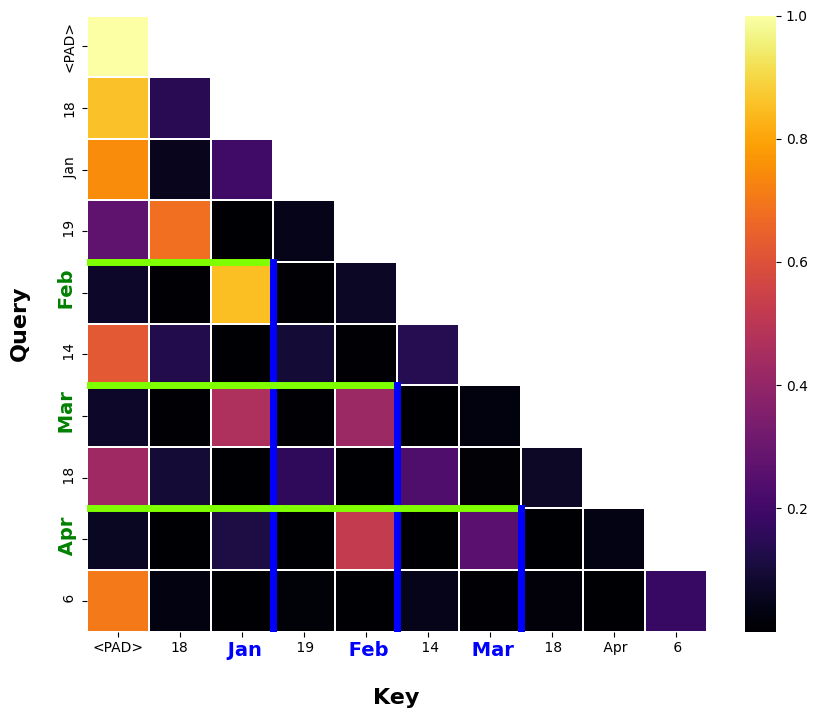

In [16]:
visualize_attention_patterns(layer = 1, head_index = 5, highlightLines=True, savePlotName='attnpat1_5_among_months')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

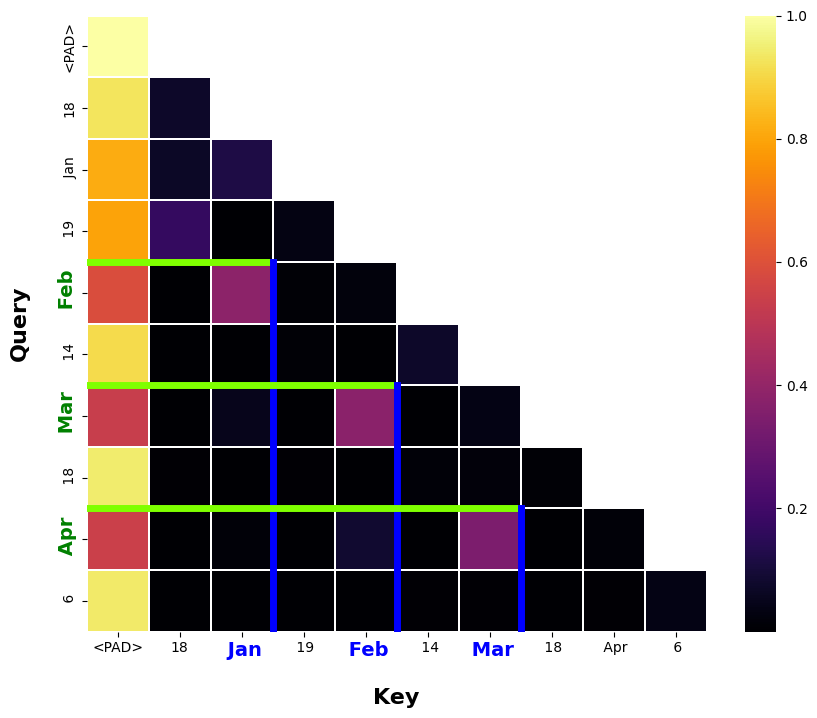

In [17]:
visualize_attention_patterns(layer = 4, head_index = 4, savePlotName='attnpat4_4_randWords')